In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

# Load and Clean Data

Data is stored in csv files. A data frame is created with the values:
- Trace - Shortened trace to be used as model input (ex. 1400 points before start of breathold, 100 points after start of breathhold)
- Csv_breath_holds - Breath hold length listed in CSV file
- Data_breath_holds - Breath hold length found using the derivative of the full trace
- Full_trace - Complete breath trace data (given in CSV file)
- breathhold_idx - Indices of the full trace identified as breathhold due to the derivative being zero
- bh_start_end - Indices of the full trace where the breathhold starts and ends (based on breathhold_idx)

In [3]:
beforeBH_len = 1400
afterBH_len = 100
trace_len = beforeBH_len+afterBH_len

In [4]:
# breath_df = get_breath_df('data_sdx_', 1400, 100, True)
# breath_df.to_pickle('breath_pickle')

In [5]:
breath_df = pd.read_pickle('breath_pickle')

In [6]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2 = under2.reset_index(drop=True)

In [7]:
trace_lens = [len(row) for row in under2['Trace']]

In [8]:
print('Average trace len:', np.mean(trace_lens), '\t75th Percentile:', np.percentile(trace_lens, 75), '\tMax trace len:',max(trace_lens))

Average trace len: 5751.174911292006 	75th Percentile: 6312.5 	Max trace len: 24720


In [9]:
# trace_len = 10000
# equalize_len_trace(under2, trace_len)

**Discrepancies:** Only considering files where the breathhold length listed in the CSV files is within 2 seconds of the breathhold length identified using the derivative of the trace to avoid using innacurate breath hold indices.

# Classification 

- **Goal:** Binary classification. "Short" breathholds are in the lower quartile of breath hold lengths and "long" breatholds are in the upper quartile of breath hold lengths.
- **Encoded as:** short (0) and long (1)

In [10]:
q25 = under2['Data_breath_holds'].quantile(.10)
q75 = under2['Data_breath_holds'].quantile(.90)

In [11]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [12]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [13]:
short = under2[under2['class']==0]
long = under2[under2['class']==1]

In [14]:
print(long.shape, short.shape)

(476, 7) (478, 7)


In [15]:
trace_lens2 = [len(row) for row in under2['Trace']]

In [16]:
max(trace_lens2)

21258

# Split and Normalize Data

In [17]:
df = under2

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.20)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)

In [20]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val
    


In [21]:
x_train2, x_val2 = normalize(x_train, x_val)

In [22]:
x_train2, x_test2 = normalize(x_train, x_test)

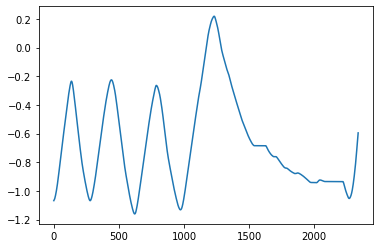

In [23]:
plt.plot(x_train2[0])

# Equalize Lengths

In [24]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [25]:
def equalize_lengths(df, trim_len):
    equal_traces = []
    for i in range(len(df)):
        curve = df[i]
        if len(curve) > trim_len:
            start_idx = len(curve)-trim_len
            equal_traces.append(curve[start_idx:])
        elif len(curve) < trim_len:
            num_zeros = trim_len - len(curve)
            
            random_nums = (np.random.random_sample(num_zeros)-0.5)
            box_pts = 100
            box = np.ones(box_pts)/box_pts
            random_nums = np.convolve(random_nums, box, mode = 'same')
            random_nums = random_nums[:num_zeros]
            #zeros = np.zeros([1, num_zeros])[0]
            equal_traces.append(np.concatenate((random_nums, curve)))
        else:
            equal_traces.append(curve)
        
        
            
    return np.array(equal_traces)

In [26]:
x_train3 = equalize_lengths(x_train2, 10000)
x_val3 = equalize_lengths(x_val2, 10000)
x_test3 = equalize_lengths(x_test2, 10000)

# Initialize Data for Model and Create DataLoader

In [27]:
#dataset
from torch.utils.data import Dataset

In [28]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [29]:
dataset = timeseries(x_train3,y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [30]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=300)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=300)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=300)

In [31]:
print("Training Shape", dataset.x.shape, dataset.y.shape)

Training Shape torch.Size([610, 10000]) torch.Size([610])


# Define LSTM Model 

In [32]:
class round_zero_decimals(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        # this can be changed for other decimal places
        n_digits = 0                                     
        exp = torch.pow(10,torch.tensor(n_digits))
        return torch.div( torch.round( input*exp ), exp)
   
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

roundActivation = round_zero_decimals.apply 

In [33]:
class myLSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=2):
        super(myLSTM_Model,self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out_pack, (ht, ct) = self.lstm(x)
        #output = output[:,-1,:] #look at yannet's code
        output = self.linear(ht[-1])
        return output
        

model = myLSTM_Model() 

In [34]:
print(model)

myLSTM_Model(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [35]:
# Initialize History
history = []

In [36]:
# Declaring Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
epochs = 15

## Training Loop

 Try predicting breathhold values
 Smaller training/simple case
 Simulated data (have amplitude be the same, only change length of breathhold)

In [37]:
trace_len = len(x_train3[0])

In [38]:
for i in range(epochs):
    
    # Training Loss
    train_loss = 0.0
    train_preds = []
    model.train()
    for x, y in train_loader:  
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        roundActivation = round_zero_decimals.apply 
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = F.binary_cross_entropy_with_logits(ypred,y.view(-1,1))   # change loss func
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        train_loss += loss.item()
        train_preds.append(ypred)
    
    # Validation Loss
    valid_loss = 0.0
    val_preds = []
    model.eval()
    for x, y in val_loader:
        # Forward Pass
        roundActivation = round_zero_decimals.apply 
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = F.binary_cross_entropy_with_logits(ypred,y.view(-1,1))
        valid_loss += loss.item()
        val_preds.append(ypred)
    
    if i%5 == 0:
        torch.save(model, 'lstm_bh')
        
    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    print(f'Epoch {i+1} \t Training cross entropy loss: {train_loss/len(train_loader)} \tValidation cross entropy loss: {valid_loss/len(val_loader)}')


Epoch 1 	 Training cross entropy loss: 0.681006133556366 	Validation cross entropy loss: 0.6542536616325378
Epoch 2 	 Training cross entropy loss: 0.6505251129468282 	Validation cross entropy loss: 0.678636908531189
Epoch 3 	 Training cross entropy loss: 0.6437262097994486 	Validation cross entropy loss: 0.7131925225257874
Epoch 4 	 Training cross entropy loss: 0.754819413026174 	Validation cross entropy loss: 0.6886511445045471
Epoch 5 	 Training cross entropy loss: 0.6791146000226339 	Validation cross entropy loss: 0.6874920725822449
Epoch 6 	 Training cross entropy loss: 0.6622509161631266 	Validation cross entropy loss: 0.7194135785102844
Epoch 7 	 Training cross entropy loss: 0.7264431715011597 	Validation cross entropy loss: 0.6930214166641235
Epoch 8 	 Training cross entropy loss: 0.6688596407572428 	Validation cross entropy loss: 0.6803905367851257
Epoch 9 	 Training cross entropy loss: 0.6690670847892761 	Validation cross entropy loss: 0.6761037707328796
Epoch 10 	 Training cr

In [39]:
torch.save(model, 'lstm_bh')

## Plot Loss

In [40]:
history = torch.tensor(history)

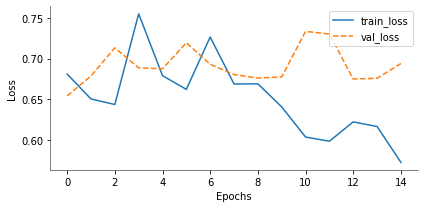

In [41]:
plot_loss(history, maxy = 50)

In [44]:
#test set actual vs predicted
test_set = timeseries(x_test3,y_test)

In [45]:
test_pred = model(test_set[:][0][0:50].view(-1,10000,1)).view(-1)

In [46]:
testloss = F.binary_cross_entropy_with_logits(test_pred.view(-1,1),test_set.y[0:50].view(-1,1))
print("Testing loss: ", testloss.detach().numpy())

Testing loss:  0.6772978
